# HW5-2: Handwritten digit recognition (Dense NN, CNN = tf.keras)

- The code in this notebook was generated using [GitHub Copilot](https://github.com/features/copilot).

## DNN

### Prompt

Generate a PyTorch Lightning MNIST classification model with the following:

- Model: 3-layer fully connected network with ReLU activations.
- Loss: Cross-entropy.
- Accuracy Metrics: Track training, validation, and test accuracy using torchmetrics.
- Optimizer: Adam optimizer with learning rate scheduler (StepLR).
- Data: MNIST dataset with normalization and transformation to tensor.
- Logger: TensorBoardLogger.
- Callbacks: LearningRateMonitor, TQDMProgressBar.
- Training: Train for 10 epochs with a batch size of 64.
- Visualization: Visualize the training set images with their label.
- Evaluation: Visualize the test set images with their true and predicted labels.

In [1]:
%load_ext tensorboard

### Create model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
import torchmetrics
import matplotlib.pyplot as plt


class MNISTModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.learning_rate = learning_rate

        # Define the model architecture
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.train_acc(logits.softmax(dim=-1), y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.val_acc(logits.softmax(dim=-1), y)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.test_acc(logits.softmax(dim=-1), y)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_acc", acc, prog_bar=True, on_step=False, on_epoch=True)

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        logits = self(x)
        y_hat = logits.argmax(dim=-1)
        return y_hat, y, x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
        return [optimizer], [scheduler]


### Prepare and visualize the dataset

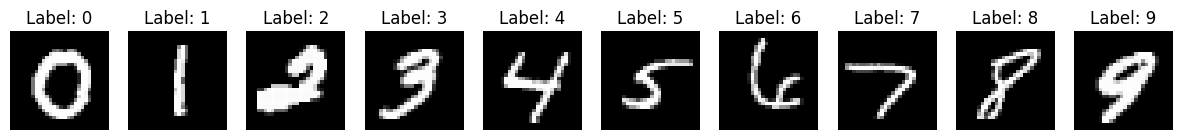

In [21]:
# Data preparation
def prepare_data():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    dataset = datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )
    mnist_test = datasets.MNIST(
        root="data", train=False, download=True, transform=transform
    )
    mnist_train, mnist_val = random_split(dataset, [55000, 5000])
    return mnist_train, mnist_val, mnist_test

def display_sample_images(dataset):
    """
    Display one sample image and its label from each class in the dataset.
    """
    class_examples = {}
    for img, label in dataset:
        if label not in class_examples:
            class_examples[label] = img
        if len(class_examples) == 10:  # We have all 10 classes (0-9)
            break

    # Plot the images with their labels
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i in range(10):
        axes[i].imshow(class_examples[i].squeeze(), cmap="gray")
        axes[i].set_title(f"Label: {i}")
        axes[i].axis("off")
    plt.show()


mnist_train, mnist_val, mnist_test = prepare_data()
display_sample_images(mnist_train)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=64)
test_loader = DataLoader(mnist_test, batch_size=64)

### Train the model
- train on the training set
- validate on the validation set

In [2]:
# Logger and Callbacks
logger = TensorBoardLogger(
    "logs5-2",
    name="mnist_dnn",
)
lr_monitor = LearningRateMonitor(logging_interval="step")
progress_bar = TQDMProgressBar(leave=True)

# Train the model
model = MNISTModel(learning_rate=1e-3)
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[lr_monitor, progress_bar],
    log_every_n_steps=10,
)
trainer.fit(model, train_loader, val_loader)

trainer.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024-12-17 00:39:14.313152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 00:39:14.324827: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 00:39:14.328458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 00:39:14.337350: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other opera

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/g113056077/.pyenv/versions/aiot-hw5/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/g113056077/.pyenv/versions/aiot-hw5/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 860/860 [00:12<00:00, 71.32it/s, v_num=0, val_loss=0.0988, val_acc=0.972, train_loss=0.0748, train_acc=0.978]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/g113056077/.pyenv/versions/aiot-hw5/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 96.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.97079998254776      │
│         test_loss         │    0.09634590148925781    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.09634590148925781, 'test_acc': 0.97079998254776}]

### Evaluate the model and visualize the results
- test on the test set

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 112.24it/s]


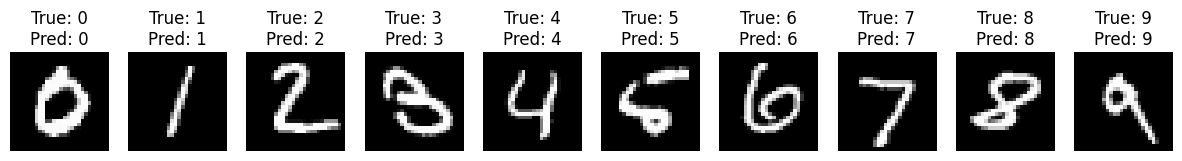

In [17]:
# Function to display one sample image per class along with true and predicted labels
def display_prediction_examples(model, dataloader):
    # Collect results from the prediction
    predictions = trainer.predict(model, dataloaders=dataloader)
    
    # Dictionary to store one sample for each class
    class_examples = {i: {'image': None, 'true_label': None, 'pred_label': None} for i in range(10)}

    for y_hat, y, x in predictions:
        for i in range(len(y)):
            label = y[i].item()
            pred_label = y_hat[i].item()

            # Store the first image for each class
            if class_examples[label]['image'] is None:
                class_examples[label]['image'] = x[i]  # Store the image
                class_examples[label]['true_label'] = label
                class_examples[label]['pred_label'] = pred_label

            # Stop once we have one image for each class
            if all(v['image'] is not None for v in class_examples.values()):
                break

        # Stop the loop if all class examples are collected
        if all(v['image'] is not None for v in class_examples.values()):
            break

    # Plot the images with true and predicted labels
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i in range(10):
        axes[i].imshow(class_examples[i]['image'].squeeze(), cmap="gray")
        axes[i].set_title(f"True: {class_examples[i]['true_label']}\nPred: {class_examples[i]['pred_label']}")
        axes[i].axis("off")
    plt.show()

# Use the test dataset to display the predictions
display_prediction_examples(model, test_loader)

## CNN

### Prompt

Replace the dnn model with a CNN model.

### Modify

- fix incorrect input shape.

### Create model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
import torchmetrics

class CNNModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.learning_rate = learning_rate

        # Define the CNN architecture
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

        # Metrics
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.train_acc(logits.softmax(dim=-1), y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.val_acc(logits.softmax(dim=-1), y)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.test_acc(logits.softmax(dim=-1), y)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_acc", acc, prog_bar=True, on_step=False, on_epoch=True)

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        logits = self(x)
        y_hat = logits.argmax(dim=-1)
        return y_hat, y, x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
        return [optimizer], [scheduler]

### Prepare and visualize the dataset

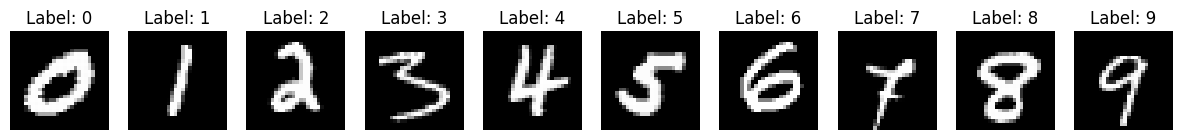

In [ ]:
# Data preparation
def prepare_data():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    dataset = datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )
    mnist_test = datasets.MNIST(
        root="data", train=False, download=True, transform=transform
    )
    mnist_train, mnist_val = random_split(dataset, [55000, 5000])
    return mnist_train, mnist_val, mnist_test


def display_sample_images(dataset):
    """
    Display one sample image and its label from each class in the dataset.
    """
    class_examples = {}
    for img, label in dataset:
        if label not in class_examples:
            class_examples[label] = img
        if len(class_examples) == 10:  # We have all 10 classes (0-9)
            break

    # Plot the images with their labels
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i in range(10):
        axes[i].imshow(class_examples[i].squeeze(), cmap="gray")
        axes[i].set_title(f"Label: {i}")
        axes[i].axis("off")
    plt.show()

mnist_train, mnist_val, mnist_test = prepare_data()
display_sample_images(mnist_train)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=64)
test_loader = DataLoader(mnist_test, batch_size=64)


### Train the model
- train on the training set
- validate on the validation set

In [3]:
# Logger and Callbacks
logger = TensorBoardLogger(
    "logs5-2",
    name="mnist_cnn",
)
lr_monitor = LearningRateMonitor(logging_interval="step")
progress_bar = TQDMProgressBar(leave=True)

# Train the model
model = CNNModel(learning_rate=1e-3)
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[lr_monitor, progress_bar],
    log_every_n_steps=10,
)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | conv1     | Conv2d             | 320    | train
1 | conv2     | Conv2d             | 18.5 K | train
2 | conv3     | Conv2d             | 73.9 K | train
3 | pool      | MaxPool2d          | 0      | train
4 | fc1       | Linear             | 147 K  | train
5 | fc2       | Linear             | 1.3 K  | train
6 | train_acc | MulticlassAccuracy | 0      | train
7 | test_acc  | MulticlassAccuracy | 0      | train
8 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
241 K     Trainable params
0         Non-trainable params
241 K     Total params
0.966     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 9: 100%|██████████| 860/860 [00:12<00:00, 70.78it/s, v_num=0, val_loss=0.0306, val_acc=0.994, train_loss=0.00198, train_acc=1.000]


`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 99.85it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9937000274658203     │
│         test_loss         │   0.023018453270196915    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.023018453270196915, 'test_acc': 0.9937000274658203}]

### Evaluate the model and visualize the results
- test on the test set

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 105.07it/s]


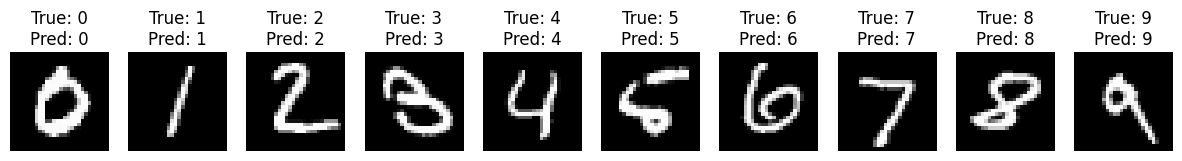

In [19]:
# Function to display one sample image per class along with true and predicted labels
def display_prediction_examples(model, dataloader):
    # Collect results from the prediction
    predictions = trainer.predict(model, dataloaders=dataloader)
    
    # Dictionary to store one sample for each class
    class_examples = {i: {'image': None, 'true_label': None, 'pred_label': None} for i in range(10)}

    for y_hat, y, x in predictions:
        for i in range(len(y)):
            label = y[i].item()
            pred_label = y_hat[i].item()

            # Store the first image for each class
            if class_examples[label]['image'] is None:
                class_examples[label]['image'] = x[i]  # Store the image
                class_examples[label]['true_label'] = label
                class_examples[label]['pred_label'] = pred_label

            # Stop once we have one image for each class
            if all(v['image'] is not None for v in class_examples.values()):
                break

        # Stop the loop if all class examples are collected
        if all(v['image'] is not None for v in class_examples.values()):
            break

    # Plot the images with true and predicted labels
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i in range(10):
        axes[i].imshow(class_examples[i]['image'].squeeze(), cmap="gray")
        axes[i].set_title(f"True: {class_examples[i]['true_label']}\nPred: {class_examples[i]['pred_label']}")
        axes[i].axis("off")
    plt.show()

# Use the test dataset to display the predictions
display_prediction_examples(model, test_loader)

In [2]:
%tensorboard --logdir "logs5-2"